In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from config import *
from plotting import *
from compressible import compressibleSimulation
from incompressible import incompressibleSimulation
from scenarios import *
from solidBC import *


In [2]:
# s = 1
# a = s **2  / config['targetNeighbors'] * np.pi
# r = np.sqrt(a / np.pi)
# print(r)

In [3]:
def getILConfig(radius = 0.23360679774997896, dt = 0.005, c = .2, device = 'cpu', precision = torch.float64):

    config = {
        'radius': radius,
        'targetNeighbors': 20,
        'restDensity': 1000,
        'dt': dt,
        'kappa':1.5,
        'viscosityConstant':0.1,
        'max_neighbors':256,
#         'device':'cpu',
    #     'device':device,
#         'precision': torch.float32,
        'precision': precision,
        'device':device,
        
        'domain':{
            'periodicX':True,
            'periodicY':True,
            'min': [-5, -5],
            'max': [5,5],
            'buffer': 2
        }
        ,
        'solidBoundary':[
            {
                'vertices': [[-1,-1],[1,-1],[1,1],[-1,1]],
                'inverted': False
            }
        ]
    }
    config['maxValue'] = torch.finfo(config['precision']).max

    config['area'] = np.pi * config['radius']**2
    config['support'] = np.sqrt(config['area'] / np.pi * config['targetNeighbors'])

    config['packing'] = minimize(lambda x: evalPacking(x,config), 0.5, method="nelder-mead").x[0]
    config['spacing'] = -minimize(lambda x: evalSpacing(x,config), 0., method="nelder-mead").x[0]
    
    D = (config['domain']['max'][1] - config['domain']['min'][1])
    spacing = config['spacing']
    packing = config['packing']
    n = int(np.ceil((D / config['support'] - 2 * spacing)/packing))
    h = D / (2 * spacing + n * packing)
    area = h**2 / config['targetNeighbors'] * np.pi
    radius = np.sqrt(area / np.pi)
#     print(D, spacing, packing, n, h, area, radius)
    
    config['radius'] = radius
    config['area'] = area
    config['support'] = h
    
    p = config['packing'] * config['support']
    nx = int(np.ceil((config['domain']['max'][0] - config['domain']['min'][0]) / p))
    ny = int(np.ceil((config['domain']['max'][1] - config['domain']['min'][1]) / p))
#     print('nx', nx)
#     print('prior', config['domain']['max'][0])
    config['domain']['max'][0] = config['domain']['min'][0] + nx * p
    config['domain']['max'][1] = config['domain']['min'][1] + ny * p
#     print('after', config['domain']['max'][0])

    minDomain = config['domain']['min']
    maxDomain = config['domain']['max']
#     print(config['domain']['min'], config['domain']['max'])
    
    config['emitters'] = [
#         {
#         'min': overallDomainMin + spacing * np.array([0,0]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0]+ 1,toMin[1]]),
#         'compression': 1.5
#     },{
#         'min': overallDomainMin + spacing * np.array([0,toMax[1]]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0] + 1,toDomain[1]+ 1]),
#         'compression': 1.5
#     }
#         ,{
#         'min': overallDomainMin + spacing * np.array([0,toMin[1] + 1]),
#         'max': overallDomainMin + spacing * np.array([toMin[0],toMax[1]-1]),
#         'compression': 1.5
#     }    
#     ,{
#         'min': overallDomainMin + spacing * np.array([toMax[0]+1,toMin[1] + 1]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0]+1,toMax[1]-1]),
#         'compression': 1.5
#     }
#         ,
#         {
#         'min': overallDomainMin + spacing * np.array([toMin[0],toMin[1]]),
#         'max': overallDomainMin + spacing * np.array([toMax[0],toMax[1]]),
#         'compression': 3.0
#     }
        {
        'min': minDomain + p / 2,
        'max': maxDomain - p / 2,
        'compression': 1.0
    }
    ]


    for emitter in config['emitters']:
        if 'radius' not in emitter:
            emitter['radius'] = config['radius']
        if 'density' not in emitter:
            emitter['density'] = config['restDensity']
        if 'type' not in emitter:
            emitter['type'] = 'once'
        if 'compression' not in emitter:
            emitter['compression'] = 1.0
        if 'velocity' not in emitter:
            emitter['velocity'] = [0.0,0.0]

    if 'gravity' not in config:
        config['gravity'] = [0,0]


    minCompression = config['maxValue']
    for emitter in config['emitters']:
        minCompression = min(minCompression, emitter['compression'])
    config['minCompression'] = minCompression

    config['domain']['virtualMin'] = config['domain']['min']
    config['domain']['virtualMax'] = config['domain']['max']
    config['domain']['min'] = config['domain']['min'] - config['domain']['buffer'] * config['support']
    config['domain']['max'] = config['domain']['max'] + config['domain']['buffer'] * config['support']
    
    addBoundaryBoundaries(config)
    if 'solidBoundary' in config:
        for boundary in config['solidBoundary']:
            boundary['polygon'] = torch.tensor(boundary['vertices'], device = config['device'], dtype = config['precision'])
        
    return config

In [4]:
def getVelocityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidVelocity'], config, simulationState, nx,ny)
    data = np.linalg.norm(uv,axis=2)
    return data
def getVelocityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidVelocity'].detach().cpu().numpy(), axis = 1)

xyPlotFn = lambda config, state, nx, ny: getVelocityXY(config, state, nx = 256, ny = 256)
scatterPlotFn = lambda config, state: getVelocityScatter(config, state)


In [5]:
def getDensityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidDensity'], config, simulationState, nx,ny)
#     data = np.linalg.norm(uv,axis=2)
    return uv

def getDensityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidDensity'].detach().cpu().numpy()


In [6]:
from periodicBC import *
from neighborhood import *
from sph import *

<IPython.core.display.Javascript object>


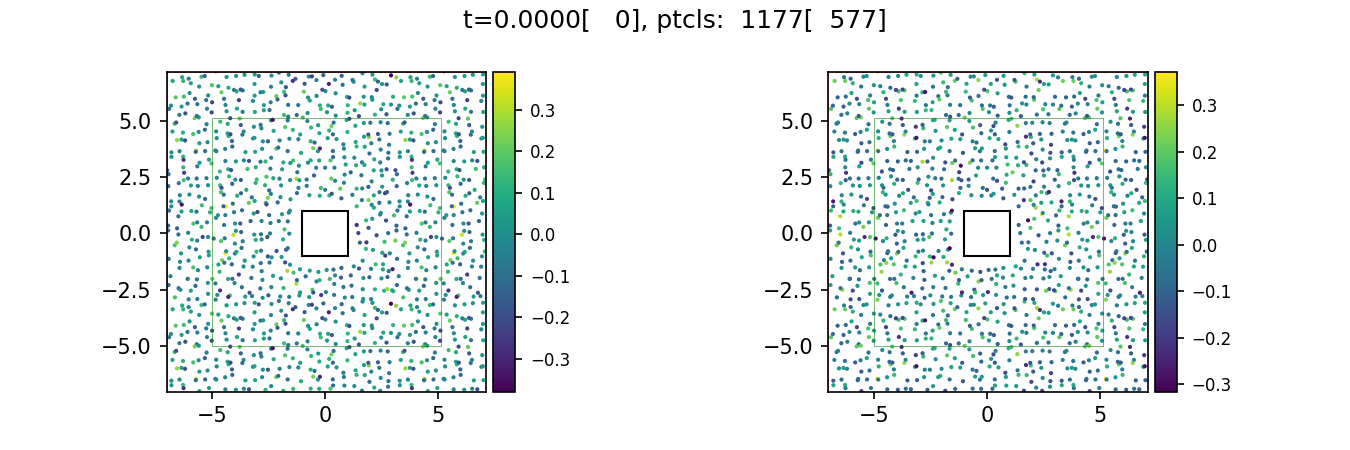

<IPython.core.display.Javascript object>


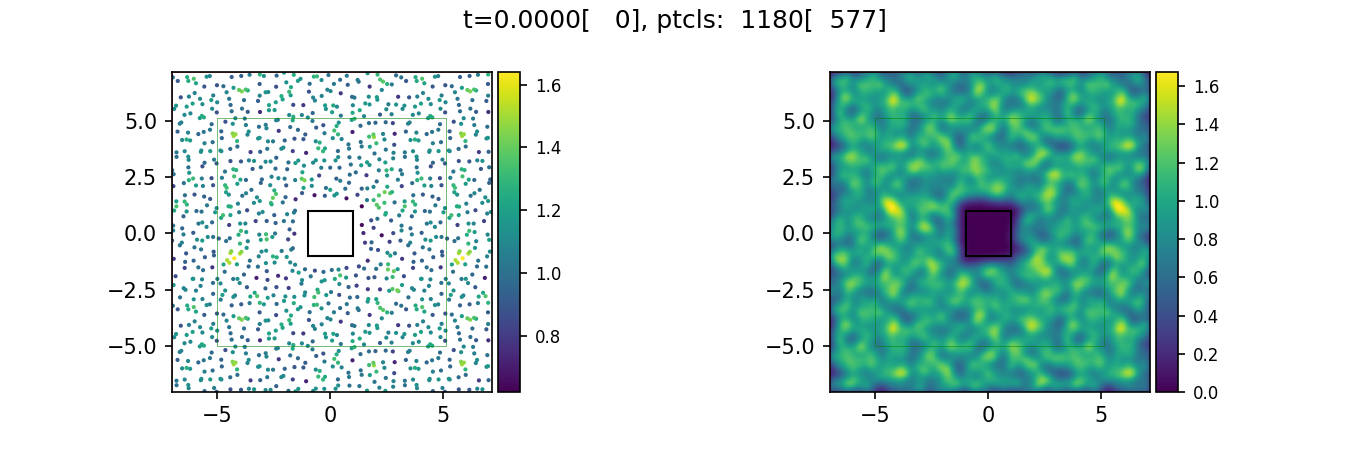

In [7]:
config = getILConfig()
simFn = lambda config, state: compressibleSimulation(config, state)

state = initializeSimulation(config)
enforcePeriodicBC(config, state)

jitter = torch.normal(torch.zeros(state['fluidPosition'].shape, device = config['device'], dtype=config['precision']))\
        * config['support'] / 8
syncQuantity(jitter, config, state)
state['fluidPosition'] += jitter


def getJitterX(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        jitter[:,0].detach().cpu().numpy()
def getJitterY(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        jitter[:,1].detach().cpu().numpy()


fig, im, axis, cbar = initialPlot(config, state,[getJitterX, getJitterY], 256, 256, figsize=(9,3), plotLayout = (1,2))

enforcePeriodicBC(config, state)

state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
    neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

state['fluidDensity'] = sphDensity(config, state)  

fig, im, axis, cbar = initialPlot(config, state,[getDensityScatter, getDensityXY], 256, 256, figsize=(9,3), plotLayout = (1,2))

In [8]:
def getUVs(qty, config, simulationState, nx = 256, ny = 256):
    x = np.linspace(config['domain']['min'][0],config['domain']['max'][0],nx)
    y = np.linspace(config['domain']['min'][1],config['domain']['max'][1],ny)
                              
    xx, yy = np.meshgrid(x, y)

    xf = xx.flatten()
    yf = yy.flatten()

    gridPositions = torch.from_numpy(np.c_[xf, yf]).type(config['precision']).to(config['device'])

    row, col = radius(simulationState['fluidPosition'], gridPositions, config['support'], max_num_neighbors = config['max_neighbors'])
    edge_index = torch.stack([row, col], dim = 0)
        
    j = edge_index[1]
    i = edge_index[0]

    pseudo = (simulationState['fluidPosition'][j] - gridPositions[i])    
    q = torch.linalg.norm(pseudo,axis=1) / config['support']
    
    kernel = wendland(q, config['support'])
    factor = kernel * simulationState['fluidArea'][j] / simulationState['fluidDensity'][j]
    if len(qty.shape) > 1:
        term = factor[:,None] * qty[j]
    else:
        term = factor * qty[j]
#     print(term.shape)
    
    out = scatter(term, i, dim=0, dim_size=gridPositions.size(0), reduce="add")

#     out = torch.tensor(gridPositions)
#     out = gridPositions[:,0]
    
    if len(qty.shape) > 1:
        uv = out.detach().cpu().numpy().reshape(ny,nx,qty.shape[1])
    else:
        uv = out.detach().cpu().numpy().reshape(ny,nx,1)

    return xx,yy,uv

<IPython.core.display.Javascript object>


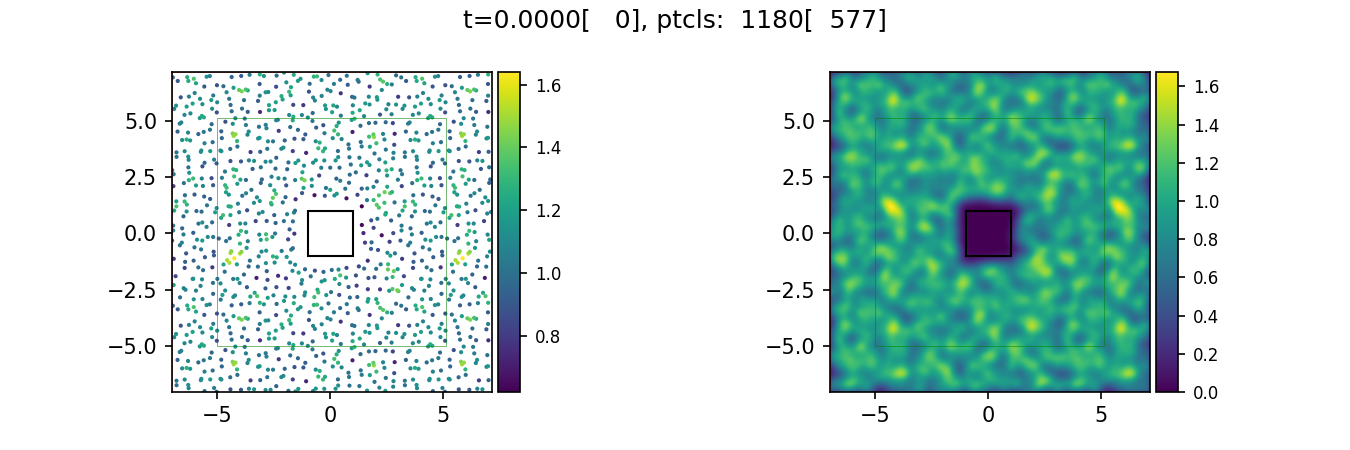

In [9]:
def getDensityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidDensity'], config, simulationState, nx,ny)
#     data = np.linalg.norm(uv,axis=2)
    return uv

fig, im, axis, cbar = initialPlot(config, state,[getDensityScatter, getDensityXY], 512, 512, figsize=(9,3), plotLayout = (1,2))

In [10]:
from kernel import *

In [11]:
def w2(config, state, reduce = True):
    neighbors = state['fluidNeighbors']
    i = neighbors[1]
    j = neighbors[0]
    fluidRadialDistances = state['fluidRadialDistances']
    
    k  = wendland(fluidRadialDistances, config['support'])
    if reduce:
        s = scatter(k, i, dim=0, dim_size=state['numParticles'], reduce="add")
        syncQuantity(s, config, state)
        return s
    return k

In [12]:
def firstDerivative(config, state, reduce = True):
    d = -state['fluidDistances']
    r =  state['fluidRadialDistances']
    
    neighbors = state['fluidNeighbors']
#     print(neighbors.shape)
    i = neighbors[1]
    j = neighbors[0]
    
    support = config['support']
    
    a = state['fluidPosition'][i]
    b = state['fluidPosition'][j]
    
    df = d.flatten().reshape(d.shape[0] * d.shape[1])
    rf = r.flatten()
    qf = rf / support
    
    x_a = a[:,0]
    x = b[:,0]
    y_a = a[:,1]
    y = b[:,1]
    
    l = torch.sqrt((x_a - x)**2 + (y_a - y)**2).flatten()
    q = l / support
    dx = (x_a - x).flatten()
    dy = (y_a - y).flatten()
    
    df = torch.zeros((dx.shape[0],2), dtype=dx.dtype, device = dx.device)
#     print(a)
#     print('x_a', x_a.shape)
#     print('x', x.shape)
#     print('dx', dx.shape)
#     print('dy', dy.shape)
#     print('l', l.shape)
#     print('df',df.shape)

    c = 7. / np.pi
    h = support
    
    df[:,0] = -(20 * c * (h **(-7))* (dx) *pow(l -h, 3)).flatten()
    df[:,1] = -(20 * c * (h **(-7))* (dy) *pow(l -h, 3)).flatten()
    
    df[q>1,0] = 0
    df[q>1,1] = 0
    if reduce:
        df = scatter(df, i, dim = 0, dim_size = state['numParticles'], reduce= "add")
        syncQuantity(df, config, state)

        return df
    return df

firstDerivative(config, state)
    

tensor([[ 4.6479, -4.3801],
        [ 5.0975, -0.7580],
        [-2.0602, -0.9760],
        ...,
        [-4.2415, -0.4848],
        [-2.2720, -0.7026],
        [-0.2639, -5.6682]], dtype=torch.float64)

In [13]:
def secondDerivative(config, state, reduce = True):
    d = -state['fluidDistances']
    r =  state['fluidRadialDistances']
    
    neighbors = state['fluidNeighbors']
    support = config['support']
#     print(neighbors.shape)
    i = neighbors[1]
    j = neighbors[0]
    
    a = state['fluidPosition'][i]
    b = state['fluidPosition'][j]
    
    df = d.flatten().reshape(d.shape[0] * d.shape[1])
    rf = r.flatten()
    qf = rf / support
    
    x_a = a[:,0]
    x = b[:,0]
    y_a = a[:,1]
    y = b[:,1]
    
    
#     df[:,0,0] = 1.
    
    c = 7. / np.pi
    h = support
    
    l = torch.sqrt((x_a - x)**2 + (y_a - y)**2).flatten()
    q = l / support
    dx = (x_a - x).flatten()
    dy = (y_a - y).flatten()
    
    df = torch.zeros((dx.shape[0],2,2), device = dx.device, dtype=dx.dtype)
    
    
    df[:,0,0] = 20 * c / h**7 * (l - h)**3
    
    df[l>0,0,0] -= (60 * c / h**7 * (l-h)**2 * dx * -dx)[l>0] / l[l>0]
    
    df[l>0,0,1] = - (60 * c / h**7 * -dx*dy * (l - h)**2)[l>0] / l[l>0]
    df[:,1,0] = df[:,0,1]
    
    df[:,1,1] = 20 * c / h**7 * (l - h)**3
    df[l>0,1,1] -= (60 * c / h**7 * (l-h)**2 * -dy * dy)[l>0] / l[l>0]
    
    df[q>1,:,:] = 0.
    
    if reduce:
        df = scatter(df, i, dim = 0, dim_size = state['numParticles'], reduce= "add")
        syncQuantity(df, config, state)

        return df
    return df
secondDerivative(config, state)

tensor([[[-13.2420,  -6.2528],
         [ -6.2528, -12.6808]],

        [[-21.4747,   3.0179],
         [  3.0179, -33.0029]],

        [[-20.4054,  -0.8139],
         [ -0.8139, -30.1811]],

        ...,

        [[-23.0082,   3.1523],
         [  3.1523, -33.9805]],

        [[-28.9446,  -4.4683],
         [ -4.4683,  12.0673]],

        [[-35.3771, -11.6690],
         [-11.6690, -40.4061]]], dtype=torch.float64)

In [14]:
def plotToGrid(data, axis):
    d = torch.clone(data)
    l = int(np.ceil(np.sqrt(data.shape[0])))
    l2 = l**2
#     padShape = d.shape
    padShape = l2 - d.shape[0]
    pad = torch.ones(padShape, device = d.device, dtype=d.dtype)  * torch.nan
    d = torch.cat((d,pad))
    d = d.reshape(l,l,-1)
    im = axis.imshow(d)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    plt.colorbar(im, cax=cax1)

In [15]:
state['fluidOmegas'] = config['area'] / state['fluidDensity']

In [16]:
def evalKernel(config, state, reduce = True):
    if reduce:
        k = w2(config, state, reduce = True)
        J = state['fluidOmegas'][:,None] * firstDerivative(config, state, reduce = True)
        H = state['fluidOmegas'][:,None,None] * secondDerivative(config, state, reduce = True)
    else:
        j = state['fluidNeighbors'][0]
        i = state['fluidNeighbors'][1]
        k = w2(config, state, reduce = False)
        J = state['fluidOmegas'][j,None] * firstDerivative(config, state, reduce = False)
        H = state['fluidOmegas'][j,None,None] * secondDerivative(config, state, reduce = False)
    return k, J, H


# fig, axis = plt.subplots(4,2, 
#     constrained_layout=True, figsize=(6,9),
#     gridspec_kw={
#         "height_ratios": [1,1,1,1],
#         "width_ratios": [1, 1],
#     },sharey = True, sharex = True)

# gs = axis[0, 0].get_gridspec()
# # remove the underlying axes
# axis[0,0].remove()
# axis[0,1].remove()
# axbig = fig.add_subplot(gs[0, 0:])

# k, J, H = evalKernel(config, state)

# i = 0

# # plotToGrid(k[i,:], axbig)

# # plotToGrid(J[i,:,0], axis[1,0])
# # plotToGrid(J[i,:,1], axis[1,1])A

# # plotToGrid(H[i,:,0,0], axis[2,0])
# # plotToGrid(H[i,:,0,1], axis[2,1])
# # plotToGrid(H[i,:,1,0], axis[3,0])
# # plotToGrid(H[i,:,1,1], axis[3,1])

# plotToGrid(k, axbig)
# axbig.set_title('Kernel Function')

# plotToGrid(J[:,0], axis[1,0])
# plotToGrid(J[:,1], axis[1,1])
# axis[1,0].set_title('∇Kernel.x')
# axis[1,1].set_title('∇Kernel.y')

# plotToGrid(H[:,0,0], axis[2,0])
# plotToGrid(H[:,0,1], axis[2,1])
# plotToGrid(H[:,1,0], axis[3,0])
# plotToGrid(H[:,1,1], axis[3,1])
# axis[2,0].set_title('∇²Kernel.xx')
# axis[2,1].set_title('∇²Kernel.xy')
# axis[3,0].set_title('∇²Kernel.yx')
# axis[3,1].set_title('∇²Kernel.yy')

# # fig.tight_layout()


In [17]:
def LinearCG(H, B, x0, tol=1e-5):    
    xk = x0
    i = state['fluidNeighbors'][1]
    j = state['fluidNeighbors'][0]
    rk = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

    rk[::2]  += scatter(H[:,0,0] * xk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    rk[::2]  += scatter(H[:,0,1] * xk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

    rk[1::2] += scatter(H[:,1,0] * xk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    rk[1::2] += scatter(H[:,1,1] * xk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")
    
    rk = rk - B
    
    pk = -rk
    rk_norm = torch.linalg.norm(rk)
    
    num_iter = 0
    while rk_norm > tol:
        apk = torch.zeros(state['numParticles'] * 2, device = config['device'], dtype=config['precision'])

        apk[::2]  += scatter(H[:,0,0] * pk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
        apk[::2]  += scatter(H[:,0,1] * pk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

        apk[1::2] += scatter(H[:,1,0] * pk[j * 2], i, dim=0, dim_size=state['numParticles'], reduce= "add")
        apk[1::2] += scatter(H[:,1,1] * pk[j * 2 + 1], i, dim=0, dim_size=state['numParticles'], reduce= "add")

        rkrk = torch.dot(rk, rk)
        
        alpha = rkrk / torch.dot(pk, apk)
        xk = xk + alpha * pk
        rk = rk + alpha * apk
        beta = torch.dot(rk, rk) / rkrk
        pk = -rk + beta * pk
        
        num_iter += 1

        rk_norm = torch.linalg.norm(rk)
    return xk

def solveShifting(config, state):
    K, J, H = evalKernel(config, state, reduce = False)

    JJ = scatter(J, state['fluidNeighbors'][1], dim=0, dim_size=state['numParticles'], reduce= "add")
    JJ -= state['boundaryGradient'] 
    
    B = torch.zeros(JJ.shape[0]*2, device = JJ.device, dtype=JJ.dtype)
    B[::2] = JJ[:,0]
    B[1::2] = JJ[:,1]
    

    x0 = torch.rand(state['numParticles'] * 2).to(config['device']).type(config['precision'])
    diff = LinearCG(H, B, x0)
    
    dx = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
    dy = torch.zeros(J.shape[0], device = J.device, dtype=J.dtype)
    dx = -diff[::2]
    dy = -diff[1::2]

    update = torch.vstack((dx,dy)).T
    syncQuantity(update, config, state)

    state['fluidUpdate'] = update


In [18]:

state['boundaryNeighbors'], state['boundaryDistances'], state['boundaryGradients'], \
    state['boundaryIntegrals'], state['boundaryIntegralGradients'], \
    state['boundaryFluidNeighbors'], state['boundaryFluidPositions'] = boundaryNeighborSearch(config, state)

state['fluidDensity'] = sphDensity(config, state)  

In [19]:

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
state['path'] = './output/%s/' %timestamp
if not os.path.exists(state['path']):
    os.makedirs(state['path'])

<IPython.core.display.Javascript object>


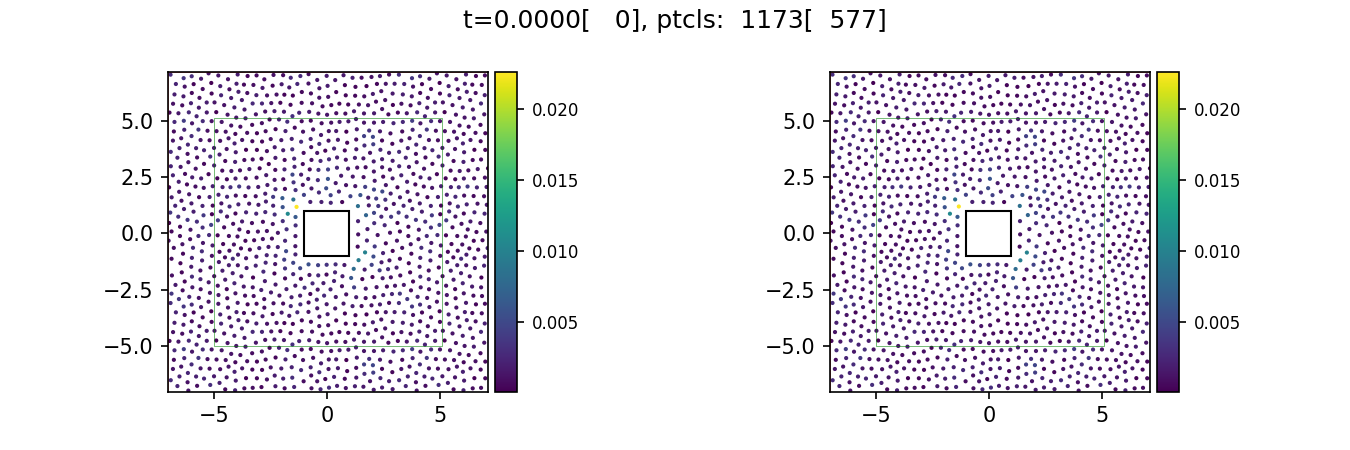

In [20]:
def getUpdateScatterX(config, simulationState):
    return (simulationState['fluidPosition'] - simulationState['fluidUpdate']).detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidUpdate'], axis = 1)
def getUpdateScatterY(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidUpdate'], axis = 1)

solveShifting(config, state)
fig, im, axis, cbar = initialPlot(config, state,[getUpdateScatterX, getUpdateScatterY], 256, 256, figsize=(9,3), plotLayout = (1,2))

imagePath = state['path'] + '%05d.png' % 0
plt.savefig(imagePath)

In [21]:
for i in tqdm(range(32)):
    solveShifting(config,state)
    state['fluidPosition'] += state['fluidUpdate']

    enforcePeriodicBC(config, state)

    state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
        neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

    state['boundaryNeighbors'], state['boundaryDistances'], state['boundaryGradients'], \
        state['boundaryIntegrals'], state['boundaryIntegralGradients'], \
        state['boundaryFluidNeighbors'], state['boundaryFluidPositions'] = boundaryNeighborSearch(config, state)

    state['fluidDensity'] = sphDensity(config, state)  
    updatePlot(config, state, fig, axis, im, cbar, [getUpdateScatterX, getUpdateScatterY], 256, 256)
    
    imagePath = state['path'] + '%05d.png' % i
    plt.savefig(imagePath)

  0%|          | 0/32 [00:00<?, ?it/s]